In [1]:
import os
from matplotlib import pyplot
%matplotlib inline
import numpy as np
import seaborn as sns
import json 
import pickle
import bilby
import get_bilby_data as gbd
from sklearn.neighbors import KernelDensity
import random


from scipy.stats import gaussian_kde

In [2]:
def get_distance_KDE(lum_d_samples, di, df, N):
    '''
    Returns a posterior density distirbution KDE for distnace based
    on the set of input distance samples associated with a given event/instance

    PARAMETERS:
    ----------
        lum_d_samples: a python array object containing sampled distance positions
        di: the bottom of the distance sampling interval [di, df]
        df: the top of the distance sampling interval [di, df]
        N: the step size of the distance sampling interval 
    '''


    #convert the data into a numpy array
    d_samples=np.array(lum_d_samples)

    #given that the distance samples range over [di, df], resolution N,
    #create and distance axis with the appropriate parameters 
    d0_axis = np.linspace(di, df, N)

    #create the probability density via KDE process 
    kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
    kde.fit(d_samples[:, None])
    logprob = kde.score_samples(d0_axis[:, None])
    distance_D=np.exp(logprob)


    #return H0 posterior 
    return kde   #<---- change later


In [3]:
def get_mod_likelihood(posterior, di, df, N):

    '''
    Returns a likelihood (mod evidence) KDE for distance based
    on the set of input distance samples associated with a given event/instance
    
    PARAMETERS:
    ----------
        posteiror: posterior density distirbution KDE for distance
        di: the bottom of the distance sampling interval [di, df]
        df: the top of the distance sampling interval [di, df]
        N: the step size of the distance sampling interval 
    '''

    #build uniform-comving priror for distance
    d= np.linspace(di,df,N)
    prior_unnormed = d*d*d
    delta_d=d[1]-d[0]
    d_prior= prior_unnormed/(sum(prior_unnormed)*delta_d)


    mod_Likelihood=posterior/d_prior

    return mod_Likelihood

In [4]:
def get_likelihood_via_path(dtrue, path, di=10, df=1000, N=1000):
    '''
    this function returns the distance likelihood KDE associated with some bilby 
    distribution, and true distance, by feeding in the path name to the 
    result.json file within the output directory.

    PARAMETERS:
    ----------
        dtrue: true distance to source in Mpc
        path: the path name to the bilby result.json data to be read in
        di: the bottom of the distance sampling interval [di, df]
        df: the top of the distance sampling interval [di, df]
        N: the step size of the distance sampling interval 
    '''

    path=path
    #calls gbd (file in dir) to get the data associated with path
    data=gbd.get_bilby_data(path)

    #returned data object has the distnace data in entry 0, column 5
    lum_dist=data[0][5]

    #use the previously defined methods to get the posterior/ the likelihood 
    distance_GW_posterior = get_distance_KDE(lum_dist, di, df, N)
    likelihood = get_mod_likelihood(distance_GW_posterior, di, df, N)

    return likelihood

In [5]:
def sample_likelihood(d_axis, likelihood, k=100000):
    '''
    This function takes in the likelihood generated by the above funtion, 
    as well as an appropriate H0 axis and number of samples to be performed, 
    and returns (A) an array of samples from the likelihood, and (B) a 
    plot displaying the sample distibrution. Since we're currently assuming 
    a uniform prior, the likelihood samples are directly proportional to 
    the actual posterior, so by normalizing we still obtain the correct 
    posterior for H0 given the gravitaitonal wave distance data. 

    PARAMETERS:
    ----------
        d_axis: a numpy array object containing a representation of
            the d axis
        likelihood: a likelihood KDE returned from get_mod_lieklihood
            or get_likelihood_via_path method
        k: number of samples to perform 
    '''

    #sample points with weights according to the likelihood
    LH_samples=random.choices(d_axis, likelihood, k=1000000)  


#                 '''
#                 <--- you have to fix this line here
#                 <--- you have to fix this line here
#                 <--- you have to fix this line here
#                     you need to:
#                         #1: see if you can trasnform the likelihood function into something
#                             more managable
#                         #2: figure out how to get an axis that matches its proper parameters
#                         #3: sample that
#                 '''



    #get the proper resolution size for the sample histogram
    d_N=len(d_axis)

    #histogram data/axis via numpy
    np_hist=np.histogram(LH_samples, d_N, density=True)  #<------ go back and change this

    #get samples
    np_samp=np_hist[0]


    #get axis; remove +1 axis size thing
    axis=np_hist[1][0:H_N]
    
    V1=sum(np_samp)     #  <------ go back and change this
    DV=axis[1]-axis[0]  #  <------ go back and change this
    print(V1*DV)        #  <------ go back and change this

    #scale likelihood KDE to a density
    posterior=likelihood/(sum(likelihood)*DV)

    #plot samples and true likelihood 
    pyplot.plot(axis,np_samp, alpha=0.3)

    pyplot.plot(d_axis, posterior, 'r', linewidth=1)
    ax = pyplot.gca()
    ylim = ax.get_ylim()
    pyplot.plot([70, 70], ylim, 'r')
    pyplot.ylim([0,max(np_samp)+0.01])
    pyplot.xlim([0, 100])
    pyplot.xlabel("$H_0$ -  Hubbles Constant (Mpc)")
    pyplot.ylabel("$p(H_0)$")

    return axis    #<------ go back and change this

In [6]:
class Likelihood:
    
    def __init__(self, data, di, df, z, f, N=10000):
        self.c=2.997e8
        
        self.kde = gaussian_kde(data)
        self.z = z
        
        self.H0_axis=np.linspace(z*self.c/df,z*self.c/di,N)
        
        self.d_prior_norm=1/(quad(f,di,df))[0]
        self.h_prior_norm=1/( (z*c/di) - (z*c/df) )
        
    
    def d_prior(self, d):
        norm_const=self.d_prior_norm
        return (d*d*d)*norm_const
    
    def h_prior(self, h):
            return self.h_prior_norm

    def H_likelihood(self):
        """
        This function takes the value of H0 and the redshift, computes
        the corresponding luminosity distance then used the KDE of the
        posterior and the priors to figure out the likelihood value at
        that point
        """
        r = self.c*self.z/(self.H0_axis)
        d_likelihood = self.kde.evaluate(r)
        d_prior = self.d_prior(r)
        h_prior = self.h_prior(self.H0_axis)
        likelihood = (d_likelihood/d_prior)*h_prior
        return likelihood

In [7]:
class JoinLikelihoods:

    def __init__(self, data, z):
        self.kde = gaussian_kde(data)
        self.z = z

    def prior_val(self, r):
        return (r**3)/(15624997499)

    def likelihood_func(self, H0):
        
        """
        This function takes the value of H0 and the redshift, computes
        the corresponding luminosity distance then used the KDE of the
        posterior and the priors to figure out the likelihood value at
        that point
        """
        
        r = 2.997e8*self.z/(H0)
        posterior = self.kde.evaluate(r)
        prior = self.prior_val(r)
        likelihood = posterior/prior
        return likelihood


In [37]:
path="bilby_runs_0.4_0.73/bilby_0.4_0.73_followup_2/bilby_0.4_0.73_followup_2_result.json"
data=gbd.get_bilby_data(path)
lum_dist=data[0][5]

H0=70
true_d=50
c=2.997e8
zt= H0*true_d/c

H0 = np.linspace(zt*c/500, zt*c/10, 10000)
LObj1 = JoinLikelihoods(lum_dist, zt)
L1 = LObj1.likelihood_func(H0)

LH_SAMPLES=random.choices(H0, L1, k=1000000) 

d_np=np.array(lum_dist)
h_np=(zt*c/d_np)

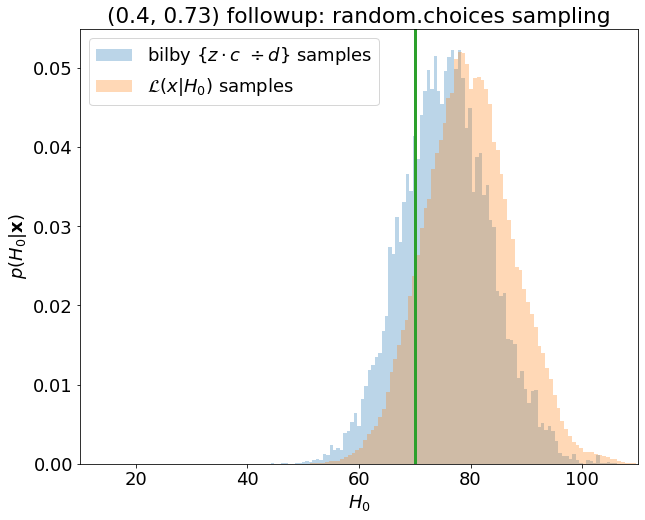

In [38]:

pyplot.rcParams.update({'font.size': 18})
pyplot.figure(figsize=(10,8))
pyplot.hist(h_np, bins=100, density=True, alpha=0.3, label="bilby $\{z \cdot c\ \div d \}$ samples");
pyplot.hist(LH_SAMPLES, bins=100, density=True, alpha=0.3, label="$\mathcal{L}( x | H_0)$ samples");
pyplot.xlabel("$H_0$")
ax = pyplot.gca()
ylim = ax.get_ylim()
pyplot.plot([70, 70], ylim, linewidth=3)
pyplot.ylim(ylim)
pyplot.xlim([10,110])
pyplot.ylabel("$p(H_0 | {\\bf x})$")
pyplot.legend()
pyplot.title("(0.4, 0.73) followup: random.choices sampling");




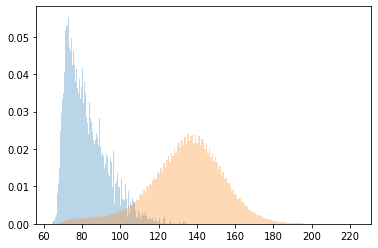

In [203]:
path="bilby_runs_5.445_0/bilby_5.445_0_followup_trueloc/bilby_5.445_0_followup_trueloc_result.json"
data=gbd.get_bilby_data(path)
lum_dist=data[0][5]

H0, true_d, c = 70, 100, 2.997e8
zt= H0*true_d/c


H0 = np.linspace(zt*c/500, zt*c/10, 10000)
LObj1 = JoinLikelihoods(lum_dist, zt)
L2 = LObj1.likelihood_func(H0)

LH_SAMPLES=random.choices(H0, L1, k=1000000) 

d_np=np.array(lum_dist)
h_np=(zt*c/d_np)

pyplot.hist(h_np, bins=200, density=True, alpha=0.3);
pyplot.hist(LH_SAMPLES, bins=200, density=True, alpha=0.3);

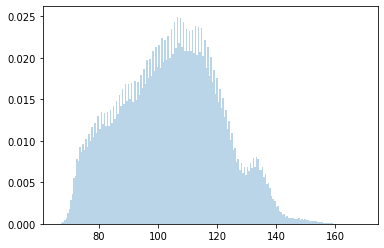

In [204]:
LH_SAMPLES=random.choices(H0, L1*L2, k=1000000)
pyplot.hist(LH_SAMPLES, bins=200, density=True, alpha=0.3);